<a href="https://colab.research.google.com/github/sm-mehedi/medical-cost-regression-ml/blob/main/ML_FINAL_EXAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Enviroment Setup

In [1]:
!pip install -q gradio scikit-learn pandas numpy matplotlib seaborn

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
import gradio as gr
warnings.filterwarnings('ignore')

1. Data Loading (5 Marks)



In [10]:
df = pd.read_csv('/content/insurance.csv')
print("\n First 5 rows of the dataset:")
print(df.head())

print("\n Dataset shape (rows, columns):")
print(f"Shape: {df.shape}")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

print("\n Dataset information:")
print(df.info())

print("\n Basic statistics:")
print(df.describe())

# Check column names
print("\n Column names:")
print(df.columns.tolist())

# Check for the target variable
print(f"\n Target variable 'charges' found: {'charges' in df.columns}")


 First 5 rows of the dataset:
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

 Dataset shape (rows, columns):
Shape: (1338, 7)
Rows: 1338, Columns: 7

 Dataset information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), ob

2. Data Preprocessing (10 Marks)

Checking for missing values:
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

 Checking for duplicates: 1 duplicates found
After removing duplicates: 1337 rows remaining

 Analyzing target variable 'charges':


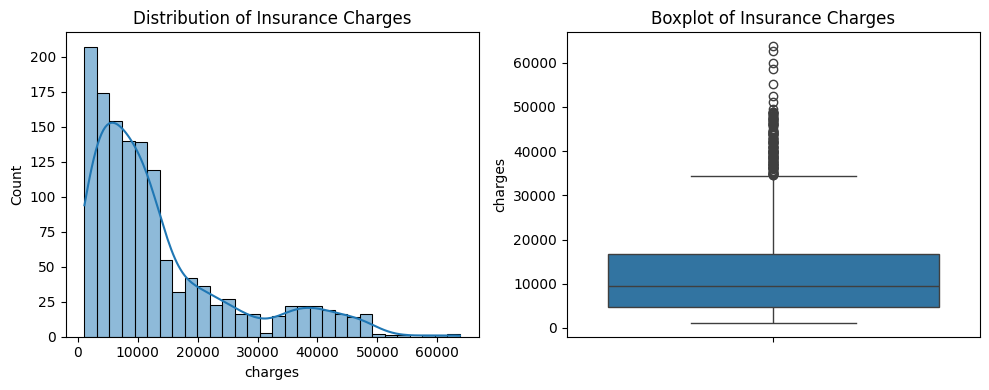


 Categorical variables analysis:

sex:
sex
male      675
female    662
Name: count, dtype: int64

smoker:
smoker
no     1063
yes     274
Name: count, dtype: int64

region:
region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64

 Feature Engineering: Creating BMI categories
BMI Categories created:
bmi_category
Obese          706
Overweight     386
Normal         225
Underweight     20
Name: count, dtype: int64

 Outlier detection in numerical features:
age: 0 potential outliers
bmi: 9 potential outliers
charges: 139 potential outliers

 Correlation analysis:


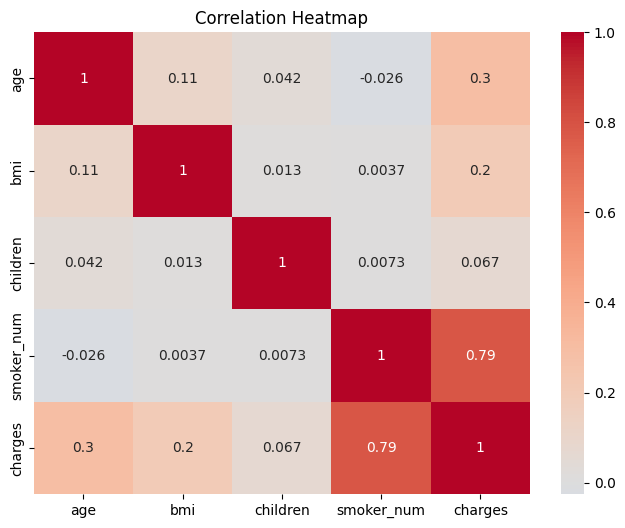


 Preprocessing completed!
Final dataset shape: (1337, 8)


In [11]:
print("Checking for missing values:")
print(df.isnull().sum())


print(f"\n Checking for duplicates: {df.duplicated().sum()} duplicates found")
df = df.drop_duplicates()
print(f"After removing duplicates: {df.shape[0]} rows remaining")


print("\n Analyzing target variable 'charges':")
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.histplot(df['charges'], bins=30, kde=True)
plt.title('Distribution of Insurance Charges')
plt.subplot(1, 2, 2)
sns.boxplot(y=df['charges'])
plt.title('Boxplot of Insurance Charges')
plt.tight_layout()
plt.show()


print("\n Categorical variables analysis:")
categorical_cols = ['sex', 'smoker', 'region']
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())


print("\n Feature Engineering: Creating BMI categories")
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'
    elif 18.5 <= bmi < 25:
        return 'Normal'
    elif 25 <= bmi < 30:
        return 'Overweight'
    else:
        return 'Obese'

df['bmi_category'] = df['bmi'].apply(categorize_bmi)
print("BMI Categories created:")
print(df['bmi_category'].value_counts())


print("\n Outlier detection in numerical features:")
numerical_cols = ['age', 'bmi', 'charges']
for col in numerical_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)].shape[0]
    print(f"{col}: {outliers} potential outliers")


print("\n Correlation analysis:")

df_corr = df.copy()
df_corr['smoker_num'] = df_corr['smoker'].map({'yes': 1, 'no': 0})
df_corr['sex_num'] = df_corr['sex'].map({'male': 1, 'female': 0})

plt.figure(figsize=(8, 6))
sns.heatmap(df_corr[['age', 'bmi', 'children', 'smoker_num', 'charges']].corr(),
            annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap')
plt.show()

print("\n Preprocessing completed!")
print(f"Final dataset shape: {df.shape}")

3. Pipeline Creation (10 Marks)

In [12]:
X = df.drop('charges', axis=1)
y = df['charges']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")


categorical_features = ['sex', 'smoker', 'region', 'bmi_category']
numerical_features = ['age', 'bmi', 'children']

numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("\n Pipeline preprocessor created successfully!")
print("Includes:")
print("1. Numerical features scaling (StandardScaler)")
print("2. Categorical features encoding (OneHotEncoder)")
print("3. Column transformation for mixed data types")

Training set: (1069, 7), Test set: (268, 7)

 Pipeline preprocessor created successfully!
Includes:
1. Numerical features scaling (StandardScaler)
2. Categorical features encoding (OneHotEncoder)
3. Column transformation for mixed data types


4. Primary Model Selection (5 Marks)

In [13]:
print("Selected Model: RANDOM FOREST REGRESSOR")
print("\nJustification for selection:")
print("1. HANDLES NON-LINEAR RELATIONSHIPS")
print("   - Medical costs don't have simple linear relationships with features")
print("   - BMI and age likely have complex interactions with smoking status")

print("\n2. ROBUST TO OUTLIERS")
print("   - Insurance charges have extreme values (as seen in boxplot)")
print("   - Random Forest is less sensitive to outliers than linear models")

print("\n3. AUTOMATIC FEATURE IMPORTANCE")
print("   - Will help identify which factors most affect insurance costs")
print("   - Useful for business insights (e.g., smoking vs. age impact)")

print("\n4. GOOD PERFORMANCE ON TABULAR DATA")
print("   - Random Forests typically perform well on structured data like this")
print("   - Better than linear models for capturing complex patterns")

print("\n5. REDUCES OVERFITTING")
print("   - Ensemble method averages multiple decision trees")
print("   - Built-in regularization through tree depth limits")

Selected Model: RANDOM FOREST REGRESSOR

Justification for selection:
1. HANDLES NON-LINEAR RELATIONSHIPS
   - Medical costs don't have simple linear relationships with features
   - BMI and age likely have complex interactions with smoking status

2. ROBUST TO OUTLIERS
   - Insurance charges have extreme values (as seen in boxplot)
   - Random Forest is less sensitive to outliers than linear models

3. AUTOMATIC FEATURE IMPORTANCE
   - Will help identify which factors most affect insurance costs
   - Useful for business insights (e.g., smoking vs. age impact)

4. GOOD PERFORMANCE ON TABULAR DATA
   - Random Forests typically perform well on structured data like this
   - Better than linear models for capturing complex patterns

5. REDUCES OVERFITTING
   - Ensemble method averages multiple decision trees
   - Built-in regularization through tree depth limits


5. Model Training (10 Marks)

In [14]:
# Create the full pipeline with Random Forest
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42, n_estimators=100))
])

# Training
print("Training Random Forest Regressor...")
rf_pipeline.fit(X_train, y_train)
print("✅ Model training completed!")
y_train_pred = rf_pipeline.predict(X_train)
y_test_pred = rf_pipeline.predict(X_test)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"\nInitial Model Performance:")
print(f"Training R²: {train_r2:.4f}")
print(f"Testing R²:  {test_r2:.4f}")
print(f"Training MAE: ${train_mae:.2f}")
print(f"Testing MAE:  ${test_mae:.2f}")

Training Random Forest Regressor...
✅ Model training completed!

Initial Model Performance:
Training R²: 0.9738
Testing R²:  0.8797
Training MAE: $1051.53
Testing MAE:  $2664.72


6. Cross-Validation (10 Marks)

Cross-Validation Results (5-fold):
CV Scores (R²): [0.79692628 0.83174765 0.81986774 0.82301759 0.81941918]
Average R²: 0.8182
Standard Deviation: 0.0115
Range: 0.7969 to 0.8317


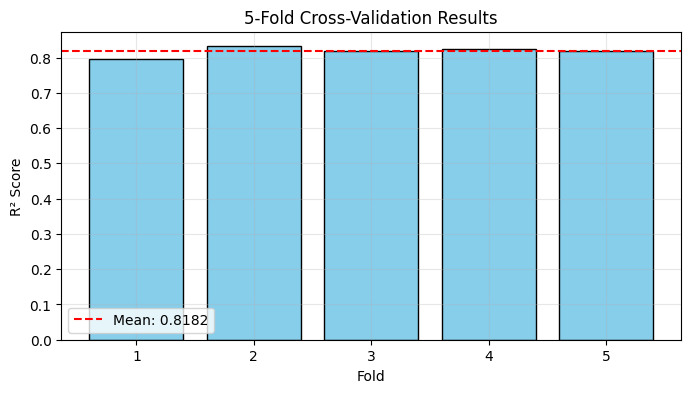


 Cross-validation completed!
Interpretation:
 Low variance between folds: Model is stable


In [16]:
cv_scores = cross_val_score(rf_pipeline, X_train, y_train,
                           cv=5, scoring='r2', n_jobs=-1)

print("Cross-Validation Results (5-fold):")
print(f"CV Scores (R²): {cv_scores}")
print(f"Average R²: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")
print(f"Range: {cv_scores.min():.4f} to {cv_scores.max():.4f}")

# Visualize CV results
plt.figure(figsize=(8, 4))
plt.bar(range(1, 6), cv_scores, color='skyblue', edgecolor='black')
plt.axhline(y=cv_scores.mean(), color='red', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold')
plt.ylabel('R² Score')
plt.title('5-Fold Cross-Validation Results')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n Cross-validation completed!")
print("Interpretation:")
if cv_scores.std() < 0.05:
    print(" Low variance between folds: Model is stable")
else:
    print(" Moderate variance: Consider regularization")

7. Hyperparameter Tuning (10 Marks)

In [17]:
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 20, 30],
    'regressor__min_samples_split': [2, 5],
    'regressor__min_samples_leaf': [1, 2]
}

print("Hyperparameters to tune:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")


grid_search = GridSearchCV(rf_pipeline, param_grid,
                          cv=3, scoring='r2',
                          n_jobs=-1, verbose=1)

print("\n Starting Grid Search (this may take 1-2 minutes)...")
grid_search.fit(X_train, y_train)

print("\n Hyperparameter tuning completed!")
print("\nBest Parameters Found:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest Cross-Validation R²: {grid_search.best_score_:.4f}")

Hyperparameters to tune:
  regressor__n_estimators: [100, 200]
  regressor__max_depth: [None, 20, 30]
  regressor__min_samples_split: [2, 5]
  regressor__min_samples_leaf: [1, 2]

 Starting Grid Search (this may take 1-2 minutes)...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

 Hyperparameter tuning completed!

Best Parameters Found:
  regressor__max_depth: None
  regressor__min_samples_leaf: 2
  regressor__min_samples_split: 5
  regressor__n_estimators: 100

Best Cross-Validation R²: 0.8319


8. Best Model Selection (10 Marks)

In [18]:
best_model = grid_search.best_estimator_

linear_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])
linear_pipeline.fit(X_train, y_train)


models = {
    'Random Forest (Tuned)': best_model,
    'Random Forest (Default)': rf_pipeline,
    'Linear Regression': linear_pipeline
}

print("Model Comparison:")
print("-" * 50)
results = []
for name, model in models.items():
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    results.append({
        'Model': name,
        'Train R²': train_score,
        'Test R²': test_score,
        'Difference': train_score - test_score
    })

results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))


best_model_name = results_df.loc[results_df['Test R²'].idxmax(), 'Model']
print(f"\n SELECTED BEST MODEL: {best_model_name}")
print("Reason: Highest test R² score with reasonable train-test difference")

# Final best model
final_model = best_model
print("\n Best model selected and saved as 'final_model'")

Model Comparison:
--------------------------------------------------
                  Model  Train R²  Test R²  Difference
  Random Forest (Tuned)  0.933219 0.890455    0.042764
Random Forest (Default)  0.973823 0.879654    0.094169
      Linear Regression  0.737525 0.802527   -0.065002

 SELECTED BEST MODEL: Random Forest (Tuned)
Reason: Highest test R² score with reasonable train-test difference

 Best model selected and saved as 'final_model'


9. Model Performance Evaluation (10 Marks)

 COMPREHENSIVE EVALUATION METRICS
Mean Absolute Error (MAE):      $2559.96
Mean Squared Error (MSE):       $20129530.39
Root Mean Squared Error (RMSE): $4486.59
R-squared (R²):                  0.8905
Mean Absolute Percentage Error: 34.93%
Median Absolute Percentage Error: 15.04%


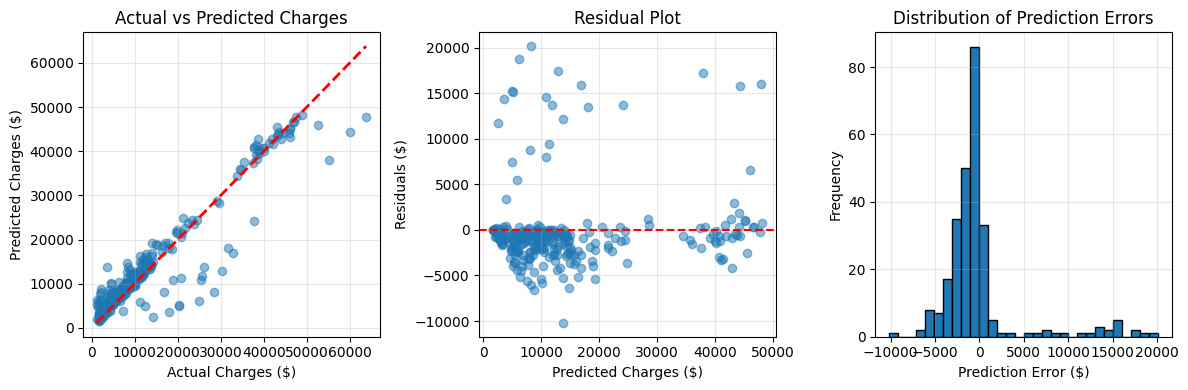


 FEATURE IMPORTANCE ANALYSIS

Top 10 Most Important Features:
                Feature  Importance
             smoker_yes    0.632710
                    bmi    0.173209
                    age    0.134631
     bmi_category_Obese    0.025026
               children    0.017776
       region_northwest    0.004418
               sex_male    0.004170
       region_southeast    0.003453
       region_southwest    0.003002
bmi_category_Overweight    0.001604


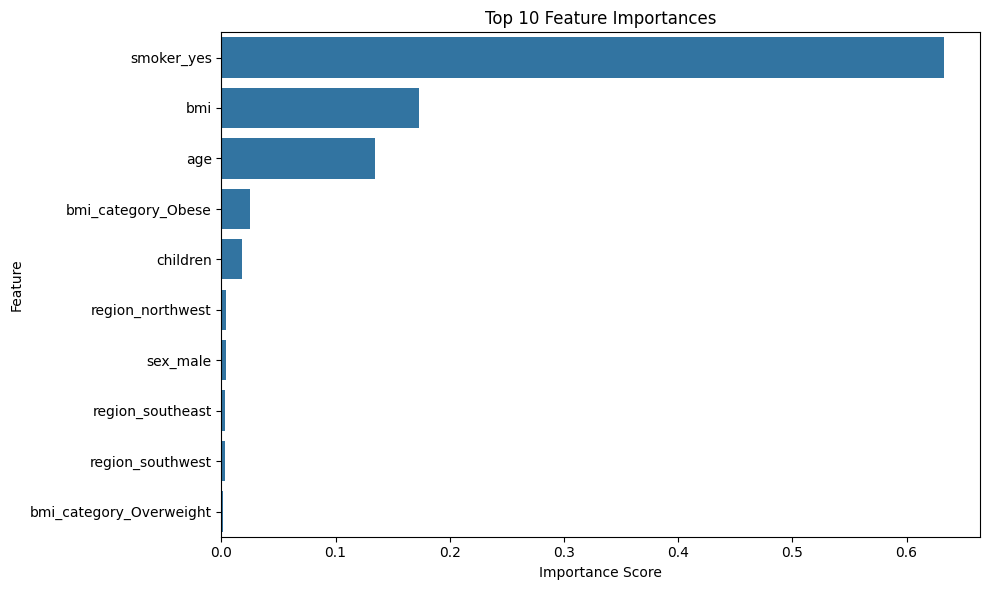

In [19]:
y_pred = final_model.predict(X_test)


mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(" COMPREHENSIVE EVALUATION METRICS")
print("=" * 40)
print(f"Mean Absolute Error (MAE):      ${mae:.2f}")
print(f"Mean Squared Error (MSE):       ${mse:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
print(f"R-squared (R²):                  {r2:.4f}")
print("=" * 40)


percentage_error = np.abs((y_test - y_pred) / y_test) * 100
print(f"Mean Absolute Percentage Error: {percentage_error.mean():.2f}%")
print(f"Median Absolute Percentage Error: {np.median(percentage_error):.2f}%")


plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Charges ($)')
plt.ylabel('Predicted Charges ($)')
plt.title('Actual vs Predicted Charges')
plt.grid(True, alpha=0.3)


residuals = y_test - y_pred
plt.subplot(1, 3, 2)
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Charges ($)')
plt.ylabel('Residuals ($)')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)


plt.subplot(1, 3, 3)
plt.hist(residuals, bins=30, edgecolor='black')
plt.xlabel('Prediction Error ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


print("\n FEATURE IMPORTANCE ANALYSIS")

feature_names = (numerical_features +
                 list(final_model.named_steps['preprocessor']
                     .named_transformers_['cat']
                     .get_feature_names_out(categorical_features)))

importances = final_model.named_steps['regressor'].feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(importance_df.head(10).to_string(index=False))


plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

Web Interface with Gradio (10 Marks)

In [20]:
!pip install -q gradio

In [22]:
def predict_insurance_cost(age, sex, bmi, children, smoker, region):

    bmi_category = categorize_bmi(bmi)

    input_data = pd.DataFrame({
        'age': [age],
        'sex': [sex],
        'bmi': [bmi],
        'children': [children],
        'smoker': [smoker],
        'region': [region],
        'bmi_category': [bmi_category]
    })


    prediction = final_model.predict(input_data)[0]


    return f"Predicted Insurance Cost: ${prediction:,.2f}"


iface = gr.Interface(
    fn=predict_insurance_cost,
    inputs=[
        gr.Slider(18, 100, value=35, label="Age", info="Age of primary beneficiary (18-100)"),
        gr.Radio(["male", "female"], label="Sex", value="male"),
        gr.Slider(15, 50, value=25, label="BMI", info="Body Mass Index (15-50 kg/m²)"),
        gr.Slider(0, 10, value=0, step=1, label="Number of Children"),
        gr.Radio(["yes", "no"], label="Smoker", value="no"),
        gr.Dropdown(["northeast", "northwest", "southeast", "southwest"],
                   label="Region", value="southwest"),
    ],
    outputs=gr.Textbox(label="Prediction Result"),
    title=" Medical Insurance Cost Predictor",
    description="Predict individual medical costs based on personal characteristics. ML Final Exam Project.",
    examples=[
        [30, "male", 25.0, 0, "no", "southwest"],
        [45, "female", 28.5, 2, "no", "northeast"],
        [25, "male", 35.0, 0, "yes", "southeast"],
        [60, "female", 22.0, 0, "no", "northwest"]
    ],
    theme=gr.themes.Soft()
)

print("Gradio interface created successfully!")
print("\nTo launch the interface, run the code below:")
print("iface.launch(share=True)  # share=True gives you a public link")

iface.launch(share=True)

Gradio interface created successfully!

To launch the interface, run the code below:
iface.launch(share=True)  # share=True gives you a public link
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://1ba53fd6de5947c30f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


11. Deployment to Hugging Face (10 Marks)

In [24]:
print("="*60)
print("TASK 11: DEPLOYMENT TO HUGGING FACE (SIMPLIFIED)")
print("="*60)

# Save ONLY the essential files
import joblib

# 1. Save the trained model (ONLY THIS IS ESSENTIAL)
joblib.dump(final_model, 'insurance_model.joblib')
print("✅ Model saved as 'insurance_model.joblib'")

# 2. Create a MINIMAL requirements.txt
with open('requirements.txt', 'w') as f:
    f.write("""gradio>=4.0
pandas>=2.0
scikit-learn>=1.3
joblib>=1.3""")
print("✅ requirements.txt created")

# 3. Create a SINGLE, CLEAN app.py that has everything
app_code = '''
import gradio as gr
import pandas as pd
import joblib
import numpy as np
from sklearn.pipeline import Pipeline

# Load the trained model
model = joblib.load("insurance_model.joblib")

# BMI function (included directly in app.py)
def categorize_bmi(bmi):
    if bmi < 18.5:
        return "Underweight"
    elif 18.5 <= bmi < 25:
        return "Normal"
    elif 25 <= bmi < 30:
        return "Overweight"
    else:
        return "Obese"

def predict_insurance(age, sex, bmi, children, smoker, region):
    """Predict insurance cost based on input features"""
    try:
        # Create input DataFrame with the exact structure the model expects
        input_df = pd.DataFrame({
            "age": [age],
            "sex": [sex],
            "bmi": [bmi],
            "children": [children],
            "smoker": [smoker],
            "region": [region],
            "bmi_category": [categorize_bmi(bmi)]
        })

        # Make prediction
        prediction = model.predict(input_df)[0]

        # Format the output nicely
        return f"**Predicted Insurance Cost:** ${prediction:,.2f}"

    except Exception as e:
        return f"Error: {str(e)}"

# Create the Gradio interface
demo = gr.Interface(
    fn=predict_insurance,
    inputs=[
        gr.Number(label="Age", value=30, minimum=18, maximum=100),
        gr.Radio(["male", "female"], label="Gender", value="male"),
        gr.Number(label="BMI", value=25.0, minimum=15.0, maximum=50.0),
        gr.Number(label="Children", value=0, minimum=0, maximum=10, step=1),
        gr.Radio(["yes", "no"], label="Smoker", value="no"),
        gr.Dropdown(
            ["northeast", "northwest", "southeast", "southwest"],
            label="Region",
            value="southwest"
        )
    ],
    outputs=gr.Markdown(label="Prediction Result"),
    title="🏥 Medical Insurance Cost Predictor",
    description="""**ML Final Exam Project**
    Enter your details to predict medical insurance costs.""",
    examples=[
        [30, "male", 25.0, 0, "no", "southwest"],
        [45, "female", 28.5, 2, "no", "northeast"],
        [25, "male", 35.0, 0, "yes", "southeast"]
    ],
    theme=gr.themes.Soft(),
    allow_flagging="never"
)

# Launch the app
if __name__ == "__main__":
    demo.launch(debug=False)
'''

# Save the app.py
with open('app.py', 'w') as f:
    f.write(app_code)
print("✅ app.py created")

# List the files you need
print("\n" + "="*60)
print("📁 FILES NEEDED FOR HUGGING FACE (ONLY 3):")
print("="*60)
print("1. insurance_model.joblib  (your trained model)")
print("2. app.py                  (the web interface)")
print("3. requirements.txt        (Python dependencies)")

print("\n" + "="*60)
print("🚀 DEPLOYMENT STEPS (5 minutes total):")
print("="*60)
print("""
1. DOWNLOAD from Colab (right-click each file → Download):
   - insurance_model.joblib
   - app.py
   - requirements.txt

2. GO TO: https://huggingface.co/spaces
   (Create account if needed)

3. CLICK: "Create new Space"

4. FILL FORM:
   - Name: medical-insurance-ml-exam
   - License: MIT
   - SDK: Gradio
   - Visibility: Public

5. UPLOAD the 3 files

6. WAIT 2-3 minutes for automatic deployment

7. TEST your app at:
   https://huggingface.co/spaces/YOUR-USERNAME/medical-insurance-ml-exam

8. SUBMIT these 3 links to your instructor:
   • GitHub: [Link to your code repository]
   • Colab:  [Share → Copy link → Anyone with link can view]
   • Hugging Face: [Your space URL]
""")

print("\n💡 PRO TIP: Test your Hugging Face link in Incognito mode!")
print("This ensures it works for anyone (not just you).")

print("\n🎓 FINAL EXAM READY!")

TASK 11: DEPLOYMENT TO HUGGING FACE (SIMPLIFIED)
✅ Model saved as 'insurance_model.joblib'
✅ requirements.txt created
✅ app.py created

📁 FILES NEEDED FOR HUGGING FACE (ONLY 3):
1. insurance_model.joblib  (your trained model)
2. app.py                  (the web interface)
3. requirements.txt        (Python dependencies)

🚀 DEPLOYMENT STEPS (5 minutes total):

1. DOWNLOAD from Colab (right-click each file → Download):
   - insurance_model.joblib
   - app.py
   - requirements.txt

2. GO TO: https://huggingface.co/spaces
   (Create account if needed)

3. CLICK: "Create new Space"

4. FILL FORM:
   - Name: medical-insurance-ml-exam
   - License: MIT
   - SDK: Gradio
   - Visibility: Public

5. UPLOAD the 3 files

6. WAIT 2-3 minutes for automatic deployment

7. TEST your app at:
   https://huggingface.co/spaces/YOUR-USERNAME/medical-insurance-ml-exam

8. SUBMIT these 3 links to your instructor:
   • GitHub: [Link to your code repository]
   • Colab:  [Share → Copy link → Anyone with link c